In [1]:
import json
with open('./football.vidi_r.json') as fp:
    graph = json.load(fp)

In [2]:
import networkx as nx
graph

{'nodes': [{'virtualNode': False,
   'height': 0,
   'idx': 0,
   'label': 'BrighamYoung',
   'ancIdx': 115,
   'childIdx': [],
   'leaf_order': 0,
   'color': '#d3eecd'},
  {'virtualNode': False,
   'height': 0,
   'idx': 1,
   'label': 'FloridaState',
   'ancIdx': 116,
   'childIdx': [],
   'leaf_order': 14,
   'color': '#4bb062'},
  {'virtualNode': False,
   'height': 0,
   'idx': 2,
   'label': 'Iowa',
   'ancIdx': 117,
   'childIdx': [],
   'leaf_order': 23,
   'color': '#157f3b'},
  {'virtualNode': False,
   'height': 0,
   'idx': 3,
   'label': 'KansasState',
   'ancIdx': 118,
   'childIdx': [],
   'leaf_order': 34,
   'color': '#fdd9b4'},
  {'virtualNode': False,
   'height': 0,
   'idx': 4,
   'label': 'NewMexico',
   'ancIdx': 115,
   'childIdx': [],
   'leaf_order': 1,
   'color': '#d3eecd'},
  {'virtualNode': False,
   'height': 0,
   'idx': 5,
   'label': 'TexasTech',
   'ancIdx': 118,
   'childIdx': [],
   'leaf_order': 35,
   'color': '#fdd9b4'},
  {'virtualNode': False,

In [7]:
indexedNodes = {}
clusters = []
for node in graph['nodes']:
    indexedNodes[node['idx']] = node

In [8]:
# construct quotient graphs
import networkx as nx
quotientGraphs = {}
for l, nodes in graph['hierarchy'].items():
    if l == '0':
        continue
    for nidx in nodes:
        node = indexedNodes[nidx]
        g = nx.Graph()
        for c in node['childIdx']:
            g.add_node(c)
        links = graph['linkInNode'][str(nidx)]
        for link in links:
            g.add_edge(link['source'], link['target'], weight=link['value'])
        quotientGraphs[nidx] = g

100%|███████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 42187.94it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


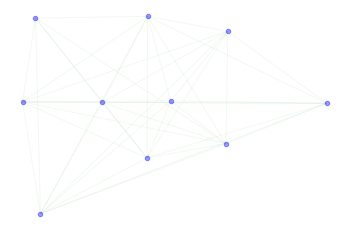

In [46]:
# layout for every quotient graph
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)
G = quotientGraphs[137]
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=20, with_labels=False, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [47]:
import numpy as np
posX = np.array([positions[i][0] for i in positions])
posY = np.array([positions[i][1] for i in positions])
maxX = posX.max()
minX = posX.min()
maxY = posY.max()
minY = posY.min()

In [87]:
# Clamp y to [0, Pi]
# Clamp x to [-pi, pi]
sPositions = {}
sx = []
sy = []
sz = []
for i, c in positions.items():
    x = (c[0] - minX) * np.pi / (maxX - minX) 
    y = -0.7 * (c[1] - minY) * np.pi / (maxY - minY)
    sx.append(np.sin(y) * np.cos(x))
    sy.append(np.sin(y) * np.sin(x))
    sz.append(np.cos(y))
    sPositions[i] = [sx[-1], sy[-1], sz[-1]]

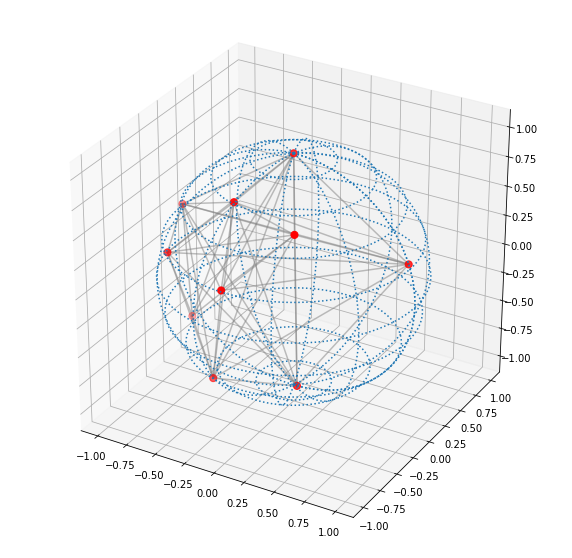

In [93]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(sx, sy, sz, c='r', s=50)

# center and radius
center = [0, 0, 0]
radius = 1

# data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

for e in G.edges():
    p1 = sPositions[e[0]]
    p2 = sPositions[e[1]]
    ax.plot([p1[0],p2[0]],[p1[1], p2[1]],[p1[2], p2[2]],color = 'gray', alpha=0.5)

ax.plot_wireframe(x, y, z, rstride=10, cstride=10, linestyle=':')

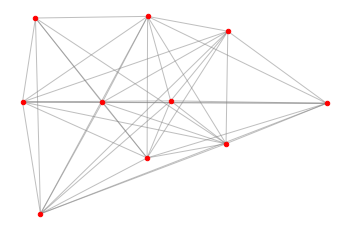

In [94]:
nx.draw_networkx_nodes(G, positions, node_size=20, with_labels=False, node_color="r", alpha=1)
nx.draw_networkx_edges(G, positions, edge_color="gray", alpha=0.5)
plt.axis('off')
plt.show()

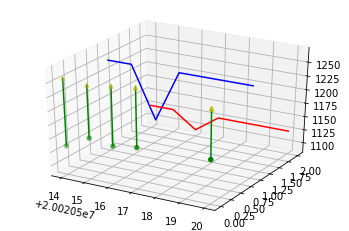

In [67]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

dates       = [20020514, 20020515, 20020516, 20020517, 20020520]
highs       = [1135, 1158, 1152, 1158, 1163]
lows        = [1257, 1253, 1259, 1264, 1252]
upperLimits = [1125.0, 1125.0, 1093.75, 1125.0, 1125.0]
lowerLimits = [1250.0, 1250.0, 1156.25, 1250.0, 1250.0]

zaxisvalues0= [0, 0, 0, 0, 0]
zaxisvalues1= [1, 1, 1, 1, 1]
zaxisvalues2= [2, 2, 2, 2, 2]

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

ax.plot(dates, zaxisvalues1, lowerLimits, color = 'b')
ax.plot(dates, zaxisvalues2, upperLimits, color = 'r')

for i,j,k,h in zip(dates,zaxisvalues0,lows,highs):
    ax.plot([i,i],[j,j],[k,h],color = 'g')

ax.scatter(dates, zaxisvalues0, highs, color = 'g', marker = "o")
ax.scatter(dates, zaxisvalues0, lows, color = 'y', marker = "^")

matplotlib.pyplot.show()

In [36]:
np.sin(np.pi / 2)

1.0